## Part II: Simulation

The inputs are the runs scored for both teams. I am going to use letters $x$ and $y$ to refer to the teams.

In the first prediction, I assume that both random variables -$rs_x$ and $rs_y$- follow a Weibull distribution whose parameters are determined in Part I.



In [4]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gamma, factorial
from datetime import datetime
import statsmodels.api as sm
import time

%load_ext autoreload
%autoreload 2
import pythagorean_expectation as pe

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# parameters

n_sim      = 1000          # number of simulations 
pe_method  = "basic"       # method of computing PE
shape      = 1.82          # common shape parameter of the Weibull dist.


In [8]:
# reading information
season_data = pd.read_csv('game_log_sorter/new_sorted_game_logs/gl2010_new_sorted.csv', header=0, index_col=0)

# this is our prediction
season_data["pred_pr(team_1_wins)"] = 0.0

In [9]:
season_data

,date,team1,team2,team1_rs,team2_rs,team1_ra,team2_ra,team1_gn,team2_gn,team1_at_bats,...,team2_win_frac_cum_pythpat,team1_past_rs,team2_past_rs,team1_past_ra,team2_past_ra,team1_past_avg_rs,team2_past_avg_rs,team1_past_avg_ra,team2_past_avg_ra,pred_pr(team_1_wins)
0,20100405,ANA,MIN,6,3,3,6,1,1,33,...,0.213787,0,0,0,0,1.000000,1.000000,1.000000,1.000000,0.0
1,20100406,ANA,MIN,3,5,5,3,2,2,33,...,0.451708,6,3,3,6,3.000000,1.500000,1.500000,3.000000,0.0
2,20100407,ANA,MIN,2,4,4,2,3,3,35,...,0.531946,9,8,8,9,3.000000,2.666667,2.666667,3.000000,0.0
3,20100408,ANA,MIN,1,10,10,1,4,4,34,...,0.702911,11,12,12,11,2.750000,3.000000,3.000000,2.750000,0.0
4,20100409,ANA,OAK,4,10,10,4,5,5,35,...,0.652496,12,17,22,13,2.400000,3.400000,4.400000,2.600000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2425,20100516,TEX,TOR,2,5,5,2,38,39,32,...,0.530686,176,193,166,168,4.631579,4.948718,4.368421,4.307692,0.0
2426,20100906,TEX,TOR,2,7,7,2,137,137,37,...,0.508526,658,635,581,602,4.802920,4.635036,4.240876,4.394161,0.0
2427,20100907,TEX,TOR,5,8,8,5,138,138,36,...,0.509094,660,642,588,604,4.782609,4.652174,4.260870,4.376812,0.0
2428,20100908,TEX,TOR,8,1,1,8,139,139,40,...,0.507472,665,650,596,609,4.784173,4.676259,4.287770,4.381295,0.0


### Change in PE 

We are assuming that after each game, the PE should not change by a large margin:

$$
|PE_{n+1} - PE_{n}| \leq \frac{\epsilon_1}{n^{\epsilon_2}}
$$

Therefore,

$$
\ln \big\{|PE_{n+1} - PE_{n}|\big\} \leq \ln \big\{\frac{\epsilon_1}{n^{\epsilon_2}}\big\} = \ln \epsilon_1 - \epsilon_2 \ln (n) 
$$

One solution to determine both parameters is to run a regression for each team, and find the average across all teams.

In [10]:
# all the teams in the seaon
teams = list(season_data.team1.unique()) + list(set(season_data.team2.unique()) - set(season_data.team1.unique()))
teams = sorted(teams).copy()

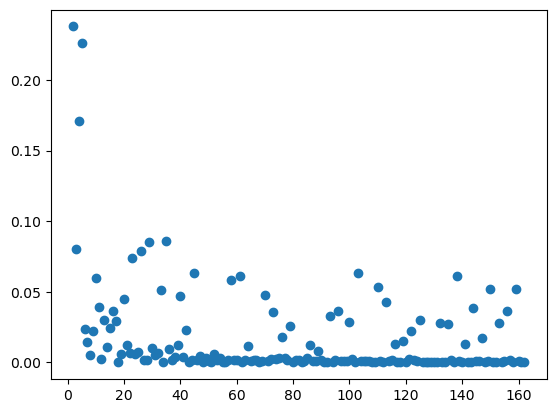

In [11]:
team = "MIN"
data_now = pe.team_season(team, season_data)
y = data_now.loc[1:, "delta_pe"]
x = data_now.loc[1:, "g_n"]
plt.scatter(x, y)

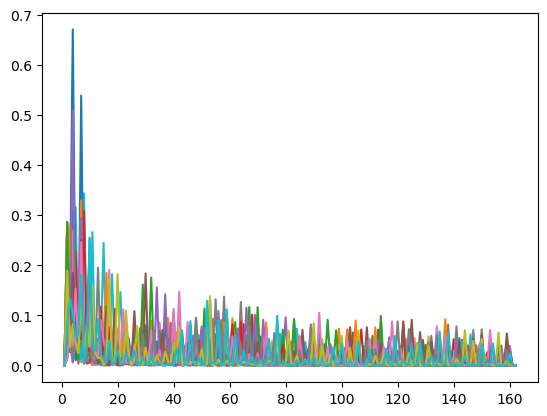

In [12]:
Result = pd.DataFrame(index = teams)

# extract entire season for a team
for team in teams:
    # dataframe for this team's season
    data_now = pe.team_season(team, season_data)
    
    # I drop the first game 
    y = np.log(data_now.loc[1:, "delta_pe"])
    x = np.log(data_now.loc[1:, "g_n"])
#     x = sm.add_constant(np.log(data_now.loc[1:, "g_n"]))
    
    # regression
    model = sm.OLS(y, x).fit()
    Result.loc[team , "epsilon"] = -1.0 * np.round(model.params[0], 4)
#     Result.loc[team , "eps_1"]   = np.round(np.exp(model.params[0]), 4)
#     Result.loc[team , "eps_2"]   = -1.0 * np.round(model.params[1], 4)
    Result.loc[team , "R2"]      = np.round(model.rsquared, 4)
    
    
    plt.plot(data_now["g_n"], data_now["delta_pe"])

In [13]:
print("Regression Results:")
print("Range for R-2  : ", Result["R2"].min(), " to ", Result["R2"].max())
# print("Range for eps  : ", Result["epsilon"].min(), " to ", Result["epsilon"].max())
# print("Average epsilon  : ", np.round(np.mean(Result["epsilon"]), 4))
# print("Average eps_1  : ", np.round(np.mean(Result["eps_1"]), 4))
# print("Average eps_2  : ", np.round(np.mean(Result["eps_2"]), 4))


Regression Results:
Range for R-2  :  0.8855  to  0.9768


In [14]:
eps1 = 1.0
eps2 = np.round(np.mean(Result["epsilon"]), 4)
# eps1 = np.round(np.mean(Result["eps_1"]), 4)
# eps2 = np.round(np.mean(Result["eps_2"]), 4)

## Simulation
All parameters of simulation are now determined. 

In [15]:
start = time.time()

for game_ind in range(len(season_data.index)):
# for game_ind in range( 1000):
    
    # 1) identify team and find stats at the end of last game
    team_1 = pe.past_stat_finder(season_data, game_ind, eps1, eps2, shape, pe_method, 1)
    team_2 = pe.past_stat_finder(season_data, game_ind, eps1, eps2, shape, pe_method, 2)

    # 2) simulation
    sim_g, rej = pe.simulation_weibull(n_sim, team_1, team_2, pe_method)

    # 3) prediction
    values, counts = np.unique(sim_g["res(team_1)"], return_counts=True)

    # fill out predicted probability column
    season_data.loc[game_ind, "pred_pr(team_1_wins)"] = int(counts[values == 1])/n_sim

    
finish = time.time()

print("run time:", (finish-start)/60, "minutes." )

run time: 24.430288724104564 minutes.


In [16]:
pe.bscore(season_data["pred_pr(team_1_wins)"], season_data["team1_win"])

0.27441567777777814

In [17]:
pe.bscore(season_data["pred_pr(team_1_wins)"], season_data["team1_win"])

0.27441567777777814

In [18]:
season_data[season_data["pred_pr(team_1_wins)"]>0]


,date,team1,team2,team1_rs,team2_rs,team1_ra,team2_ra,team1_gn,team2_gn,team1_at_bats,...,team2_win_frac_cum_pythpat,team1_past_rs,team2_past_rs,team1_past_ra,team2_past_ra,team1_past_avg_rs,team2_past_avg_rs,team1_past_avg_ra,team2_past_avg_ra,pred_pr(team_1_wins)
0,20100405,ANA,MIN,6,3,3,6,1,1,33,...,0.213787,0,0,0,0,1.000000,1.000000,1.000000,1.000000,0.480
1,20100406,ANA,MIN,3,5,5,3,2,2,33,...,0.451708,6,3,3,6,3.000000,1.500000,1.500000,3.000000,0.498
2,20100407,ANA,MIN,2,4,4,2,3,3,35,...,0.531946,9,8,8,9,3.000000,2.666667,2.666667,3.000000,0.722
3,20100408,ANA,MIN,1,10,10,1,4,4,34,...,0.702911,11,12,12,11,2.750000,3.000000,3.000000,2.750000,0.551
4,20100409,ANA,OAK,4,10,10,4,5,5,35,...,0.652496,12,17,22,13,2.400000,3.400000,4.400000,2.600000,0.481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2425,20100516,TEX,TOR,2,5,5,2,38,39,32,...,0.530686,176,193,166,168,4.631579,4.948718,4.368421,4.307692,0.495
2426,20100906,TEX,TOR,2,7,7,2,137,137,37,...,0.508526,658,635,581,602,4.802920,4.635036,4.240876,4.394161,0.618
2427,20100907,TEX,TOR,5,8,8,5,138,138,36,...,0.509094,660,642,588,604,4.782609,4.652174,4.260870,4.376812,0.599
2428,20100908,TEX,TOR,8,1,1,8,139,139,40,...,0.507472,665,650,596,609,4.784173,4.676259,4.287770,4.381295,0.565


0.250923311111111

In [81]:
values, counts = np.unique(sim_g["res(team_1)"], return_counts=True)
print("Pr(team_1_wins)  =  ", counts[values == 1]/n_sim)
print("Pr(team_2_wins)  =  ", counts[values == -1]/n_sim)

For team x, Pr(win)  =   0.681
For team x, Pr(lose) =   0.319


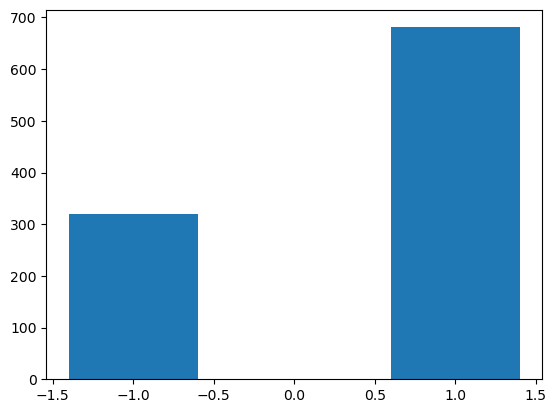

In [84]:
plt.bar(values, counts)
plt.show()

<Axes: title={'center': 'Predicted Runs by Team1'}, xlabel='rs_1', ylabel='Count'>

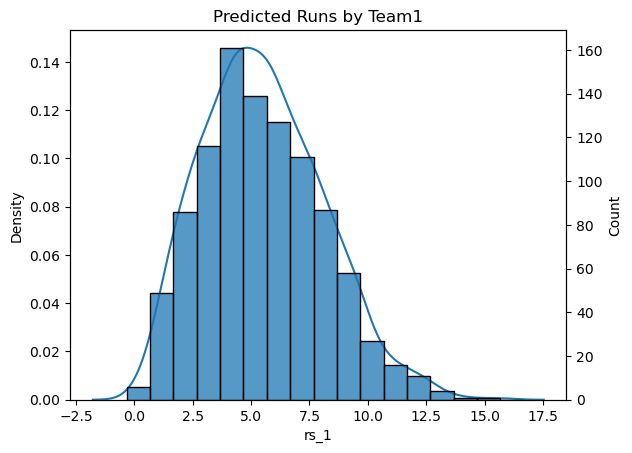

In [85]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title ("Predicted Runs by Team1")

sns.kdeplot(data = sim_g, x = "rs_1", ax = ax1)
sns.histplot(data= sim_g, x = "rs_1", ax = ax2, discrete=True)


<Axes: title={'center': 'Predicted Runs by Team 2'}, xlabel='rs_2', ylabel='Count'>

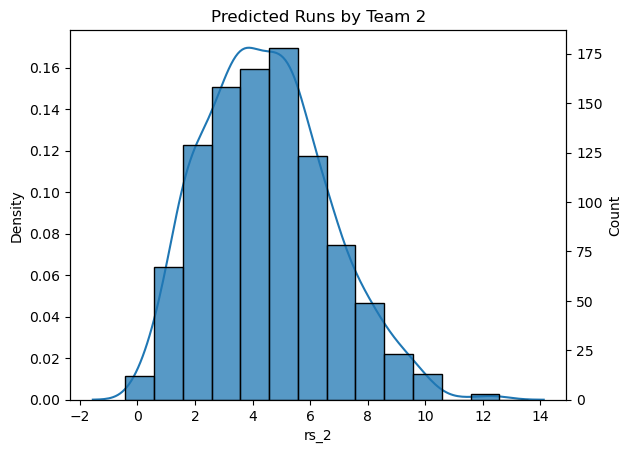

In [86]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title ("Predicted Runs by Team 2")

sns.kdeplot(data = sim_g, x = "rs_2", ax = ax1)
sns.histplot(data= sim_g, x = "rs_2", ax = ax2, discrete=True)